# Beijing House Price Predictions

credit to Dmitrii Kislenko on Kaggle for some data exploration ideas

import packages

In [1]:
%load_ext lab_black
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import lightgbm as lgbm
from sklearn.metrics import mean_squared_log_error

import data

In [2]:
houses = pd.read_csv(
    "../price_prediction_model/data/beijing_house_prices_2012_2017.csv",
    encoding="gbk",
    low_memory=False,
)

In [3]:
houses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 318851 entries, 0 to 318850
Data columns (total 26 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   url                  318851 non-null  object 
 1   id                   318851 non-null  object 
 2   Lng                  318851 non-null  float64
 3   Lat                  318851 non-null  float64
 4   Cid                  318851 non-null  int64  
 5   tradeTime            318851 non-null  object 
 6   DOM                  160874 non-null  float64
 7   followers            318851 non-null  int64  
 8   totalPrice           318851 non-null  float64
 9   price                318851 non-null  int64  
 10  square               318851 non-null  float64
 11  livingRoom           318851 non-null  object 
 12  drawingRoom          318851 non-null  object 
 13  kitchen              318851 non-null  int64  
 14  bathRoom             318851 non-null  object 
 15  floor            

## Data Preprocessing

missing data ratio

In [4]:
houses.isnull().sum() / len(houses)

url                    0.000000
id                     0.000000
Lng                    0.000000
Lat                    0.000000
Cid                    0.000000
tradeTime              0.000000
DOM                    0.495457
followers              0.000000
totalPrice             0.000000
price                  0.000000
square                 0.000000
livingRoom             0.000000
drawingRoom            0.000000
kitchen                0.000000
bathRoom               0.000000
floor                  0.000000
buildingType           0.006338
constructionTime       0.000000
renovationCondition    0.000000
buildingStructure      0.000000
ladderRatio            0.000000
elevator               0.000100
fiveYearsProperty      0.000100
subway                 0.000100
district               0.000000
communityAverage       0.001452
dtype: float64

According to the data dictionary, we can safely assume the missing days on market are all for new houses, we will fill them with the median days active on market

In [5]:
houses["DOM"] = houses["DOM"].fillna(houses["DOM"].median())

0.6% of building type is missing, we could potentially assume it's the majority type of building, as it probably will not affect the results by a large margin

In [6]:
houses["buildingType"].value_counts()

4.000    172405
1.000     84541
3.000     59715
2.000       137
0.500        15
0.333         5
0.048         4
0.125         3
0.250         2
0.429         1
0.375         1
0.667         1
Name: buildingType, dtype: int64

buildingType should be a categorical variable, any value less than 1 should just be 1

In [7]:
houses["buildingType"] = houses["buildingType"].apply(lambda x: 1 if x < 1 else x)
houses["buildingType"] = houses["buildingType"].fillna(0)
houses["buildingType"].value_counts()

4.0    172405
1.0     84573
3.0     59715
0.0      2021
2.0       137
Name: buildingType, dtype: int64

community average missing values should be filled in with the mean of that district

In [8]:
houses["communityAverage"] = houses.groupby("Cid").transform(
    lambda x: x.fillna(x.mean())
)

In [9]:
houses[houses["id"] == "BJCP00480005"]

,url,id,Lng,Lat,Cid,tradeTime,DOM,followers,totalPrice,price,...,buildingType,constructionTime,renovationCondition,buildingStructure,ladderRatio,elevator,fiveYearsProperty,subway,district,communityAverage
93514,https://bj.lianjia.com/chengjiao/BJCP00480005....,BJCP00480005,116.301903,40.117228,1111027382234,2011-09-29,6.0,0,97.5,12492,...,4.0,1996,1,4,0.5,0.0,0.0,0.0,6,116.301903


missing fiveYearsProperty will simply be dropped

In [10]:
houses.dropna(subset=["fiveYearsProperty"], inplace=True)

In [11]:
houses["livingRoom"].value_counts()

2    160589
1     82386
3     67611
4      6821
5      1107
6       228
7        37
0        28
8         7
9         5
Name: livingRoom, dtype: int64

fill the special values 0 and non-unicode chars with year 2018

In [12]:
houses["constructionTime"] = houses["constructionTime"].astype("str")
houses.loc[
    (houses.constructionTime == "0") | (houses.constructionTime == "未知"),
    "constructionTime",
] = "2018"

fill the special values 1 with year 2017

In [13]:
houses.loc[houses.constructionTime == "1", "constructionTime"] = "2017"

data type conversions

In [14]:
houses[["livingRoom", "drawingRoom", "bathRoom"]] = houses[
    ["livingRoom", "drawingRoom", "bathRoom"]
].astype(int)

In [15]:
houses["bathRoom"].value_counts()

1    261488
2     52606
3      3240
0       915
4       489
5        69
6         9
7         3
Name: bathRoom, dtype: int64

In [16]:
houses[["livingRoom", "drawingRoom", "bathRoom"]].dtypes.to_dict()

{'livingRoom': dtype('int64'),
 'drawingRoom': dtype('int64'),
 'bathRoom': dtype('int64')}

Building total floors

In [17]:
houses["buildingTotalFloors"] = houses["floor"].str.split(" ").str[1].astype(int)

In [18]:
houses["buildingTotalFloors"].head().to_dict()

{0: 26, 1: 22, 2: 4, 3: 21, 4: 6}

House floor region in building

In [19]:
height_char_mapping = {"顶": "5", "高": "4", "中": "3", "低": "2", "底": "1", "未知": "0"}
houses["floorProximity"] = (
    houses["floor"].str.split(" ").str[0].map(height_char_mapping)
)

In [20]:
houses["floorProximity"].value_counts(sort=False).to_dict()

{'1': 26080, '5': 37406, '0': 1271, '2': 64136, '3': 119832, '4': 70094}

add house age in years feature

In [21]:
houses["year"] = pd.to_datetime(houses["constructionTime"])
houses["houseAgeYears"] = round(
    (dt.datetime.today() - houses["year"]).dt.days / 365
).astype(int)

In [22]:
houses = houses.rename({"totalPrice": "totalPrice_per_10000"}, axis="columns")

average price per year

In [23]:
houses["tradeYear"] = pd.to_datetime(houses["tradeTime"]).dt.year
houses["tradeMonth"] = pd.to_datetime(houses["tradeTime"]).dt.month
houses = houses[houses["tradeYear"] >= 2011]

Text(0.5, 1.0, 'Average Price by Month')

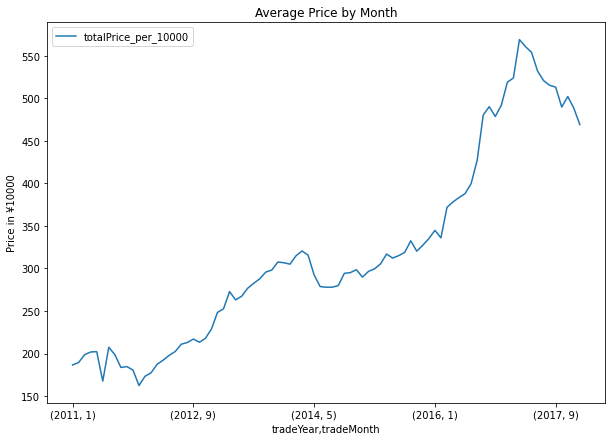

In [24]:
pd.DataFrame(
    houses[houses["tradeYear"] >= 2011]
    .groupby(["tradeYear", "tradeMonth"])
    .mean()["totalPrice_per_10000"]
).plot(figsize=(10, 7))
plt.ylabel("Price in ¥10000")
plt.title("Average Price by Month")

Create a feature of average price of house sales with expotential decay of last 3 months 

In [25]:
def get_ewma_average_price_past_3_mon(houses):
    average_prices = pd.DataFrame(
        houses[houses["tradeYear"] >= 2011]
        .groupby(["tradeYear", "tradeMonth"])
        .mean()["totalPrice_per_10000"]
    )
    return average_prices.ewm(span=3).mean().to_dict()["totalPrice_per_10000"]

In [26]:
mapping = get_ewma_average_price_past_3_mon(houses)
houses["3_month_avg_price"] = houses.apply(
    lambda x: mapping[(x["tradeYear"], x["tradeMonth"])], axis=1
)

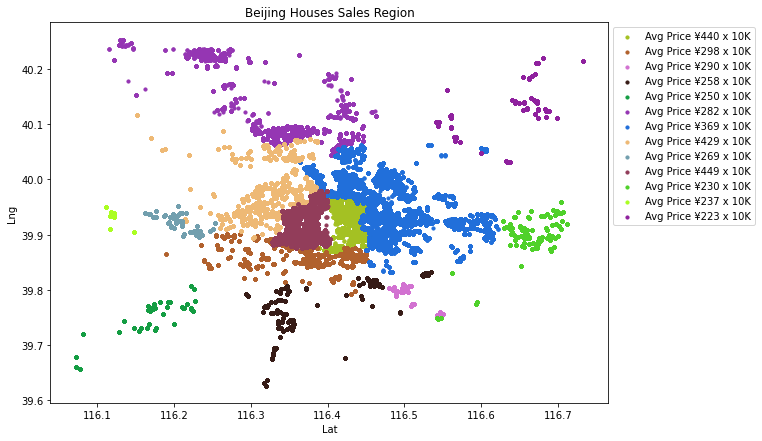

In [27]:
import random

district_avg_price = list(houses.groupby("district").mean()["totalPrice_per_10000"])

number_of_colors = max(houses["district"])
random.seed(7)
color = [
    "#" + "".join([random.choice("0123456789ABCDEF") for j in range(6)])
    for i in range(number_of_colors)
]
plt.figure(figsize=(10, 7))

for i in range(number_of_colors):
    district_houses = houses[houses["district"] == i + 1]
    plt.scatter(
        district_houses["Lng"],
        district_houses["Lat"],
        c=color[i],
        s=10,
        label=f"Avg Price ¥{round(district_avg_price[i])} x 10K",
    )

plt.title("Beijing Houses Sales Region")
plt.legend(bbox_to_anchor=(1, 1), loc="upper left")
plt.xlabel("Lat")
plt.ylabel("Lng")
plt.show()

In [28]:
houses.columns

Index(['url', 'id', 'Lng', 'Lat', 'Cid', 'tradeTime', 'DOM', 'followers',
       'totalPrice_per_10000', 'price', 'square', 'livingRoom', 'drawingRoom',
       'kitchen', 'bathRoom', 'floor', 'buildingType', 'constructionTime',
       'renovationCondition', 'buildingStructure', 'ladderRatio', 'elevator',
       'fiveYearsProperty', 'subway', 'district', 'communityAverage',
       'buildingTotalFloors', 'floorProximity', 'year', 'houseAgeYears',
       'tradeYear', 'tradeMonth', '3_month_avg_price'],
      dtype='object')

In [29]:
categorical_features = [
    "renovationCondition",
    "buildingStructure",
    "district",
    "floorProximity",
    "subway",
]
for feature in categorical_features:
    houses[feature] = pd.Series(houses[feature], dtype="category")

In [30]:
houses = houses.drop(
    ["url", "id", "Cid", "year", "tradeTime", "floor", "price", "constructionTime"],
    axis=1,
)

In [31]:
houses["communityAverage"]

0         116.475489
1         116.453917
2         116.561978
3         116.438010
4         116.428392
             ...    
318846    116.546899
318847    116.497474
318848    116.497256
318849    116.501794
318850    116.497474
Name: communityAverage, Length: 318636, dtype: float64

### Train test split

split by the last 10% as the test set

In [32]:
train_split_index = int(len(houses) * 0.9)
val_split_index = int(len(houses) * 0.91)
trainiing_data = houses.sort_values(by="tradeYear").iloc[:train_split_index]
validation_data = houses.sort_values(by="tradeYear").iloc[
    train_split_index:val_split_index
]
test_data = houses.sort_values(by="tradeYear").iloc[val_split_index:]

In [33]:
X_train, y_train = (
    trainiing_data.drop(["totalPrice_per_10000"], axis=1),
    trainiing_data["totalPrice_per_10000"],
)

X_val, y_val = (
    validation_data.drop(["totalPrice_per_10000"], axis=1),
    validation_data["totalPrice_per_10000"],
)

X_test, y_test = (
    test_data.drop(["totalPrice_per_10000"], axis=1),
    test_data["totalPrice_per_10000"],
)

In [34]:
list(set(list(X_train.index)) & set(list(X_val.index)))

[]

In [35]:
X_train.columns

Index(['Lng', 'Lat', 'DOM', 'followers', 'square', 'livingRoom', 'drawingRoom',
       'kitchen', 'bathRoom', 'buildingType', 'renovationCondition',
       'buildingStructure', 'ladderRatio', 'elevator', 'fiveYearsProperty',
       'subway', 'district', 'communityAverage', 'buildingTotalFloors',
       'floorProximity', 'houseAgeYears', 'tradeYear', 'tradeMonth',
       '3_month_avg_price'],
      dtype='object')

### LightGBM regression

In [36]:
lightgbm = lgbm.LGBMRegressor()
lightgbm.fit(X_train.values, y_train.values)

LGBMRegressor()

In [37]:
y_pred = lightgbm.predict(X_test.values)

In [38]:
print(
    "The rmse of prediction is:",
    round(mean_squared_log_error(y_pred, y_test.values) ** 0.5, 5),
)

The rmse of prediction is: 0.16692


In [39]:
lightgbm.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

LightGBM regression performed relatively well out of the box, we can try a hyperparameters set

In [40]:
hyper_params = {
    "boosting_type": "gbdt",
    "class_weight": None,
    "colsample_bytree": 1.0,
    "importance_type": "split",
    "learning_rate": 0.1,
    "max_depth": -1,
    "min_child_samples": 20,
    "min_child_weight": 0.001,
    "min_split_gain": 0.0,
    "n_estimators": 100,
    "n_jobs": -1,
    "num_leaves": 31,
    "objective": None,
    "random_state": None,
    "reg_alpha": 0.0,
    "reg_lambda": 0.0,
    "silent": True,
    "subsample": 1.0,
    "subsample_for_bin": 200000,
    "subsample_freq": 0,
}

In [41]:
lightgbm = lgbm.LGBMRegressor(**hyper_params)
lightgbm.fit(
    X_train.values,
    y_train.values,
    eval_metric="l2",
    eval_set=[(X_val.values, y_val.values)],
    early_stopping_rounds=5000,
    verbose=0,
)

LGBMRegressor()

In [42]:
y_pred = lightgbm.predict(X_test, num_iteration=lightgbm.best_iteration_)

In [43]:
print(
    "The rmse of prediction is:",
    round(mean_squared_log_error(y_pred, y_test.values) ** 0.5, 5),
)

The rmse of prediction is: 0.2097


Looks like the out of bag lightgbm model works better than the fixed parameters ones